ФИО: Грехов М.А.

Телеграм: https://t.me/Lotrein46

# Описание проекта

**Цель работы**: разработать алгоритм, который для всех товаров из ***validation.csv*** предложит несколько вариантов наиболее похожих товаров из датасета **base.csv**.

**Условия**:
- оценить качество алгоритма по метрике accuracy@5;
- использовать faiss или аналогичные инструменты, использующие метод приближённого поиска ближайших соседей.

# Импорты и загрузки

## Установка faiss-cpu в Colab

Производим установку библиотеки для Colab:

In [1]:
!pip install faiss-cpu
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 43.7 MB/s eta 0:00:0000:0100:01


## Импорт библиотек и функций

Импортируем все необходимые библиотеки и функции для работы:

In [2]:
import pandas as pd
import numpy as np
import faiss
import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostClassifier
from joblib import Parallel, delayed
import catboost

Импортируем функции и библиотеки для того, чтобы получить все необходимые данные из Яндекс.Диска.

In [3]:
import zipfile
import requests
from urllib.parse import urlencode

## Загрузка данных из yandex.drive на виртуальный диск Colab

Загружаем датасеты в Colab:

In [4]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('data.zip', 'wb') as f:   # Здесь указываем нужный путь к файлу
    f.write(download_response.content)

# Указываем путь к zip-архиву
zip_path = '/kaggle/working/data.zip'

# Распаковка zip-архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()
    

## Подготовка типов данных

Подготоавливаем словарь для корректной загрузки типов данных.

По умолчанию данные в Pandas загружаются с типом данных ***float64*** (до 15-17 знаков после запятой в зависимости от числа).
В датасетах текущего проекта все значения имеют 6 знаков после запятой, поэтому тип данных ***float64*** будет для нас избыточным и может замедлить вычисления.

Вместо этого будет использовать болеее "лёгкий" тип данных - ***float32*** (до 7 знаков после запятой).

Поле с целевым признаком в в тренировочном датасете ссылается на id товара, представляющего из себя текстовое значение. Поэтому таргет преобразовываем в ***str***.


In [5]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

# Обзор данных и предобработка

Для проекта предоставлено 4 датасета:
- **train.csv** - тренировочный датасет. Имеет поле с целевым признаком. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков и id товара из base.csv, который максимально похож на него **по мнению экспертов**;
- **base.csv** - тестовый датасет. Поле с целевым признаком отсутствует, его требуется расчитать. Представляет из себя нонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72;
- **validation.csv** - валидационный датасет. Список товаров (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
- **validation_answer.csv** - датасет с правильными ответами для оценки.

## Загрузка и обзор base.csv

Загрузим датасет **base.csv** в переменную `df_base` и посмотрим на 5 случайных записей из таблицы.

Сразу же переведём типы данных во ***float32*** с помощью словаря `dict_base`.

In [6]:
df_base = pd.read_csv("/kaggle/working/base.csv", index_col=0, dtype=dict_base)

In [7]:
df_base.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
3684278-base,-95.828773,6.694075,8.162422,-160.631561,163.534821,-26.187984,-587.313232,-31.449930,118.705261,196.744995,...,-53.496647,35.417824,-136.608444,-21.522045,67.507423,31.049480,135.200378,109.517586,-1235.891968,-54.731377
3735740-base,-25.258259,1.788570,-52.000721,-112.871262,146.716614,-90.828850,50.703190,-32.959602,129.201706,89.726959,...,-55.537651,25.928520,-129.625153,101.027618,67.610367,72.315552,77.598747,106.425339,-1074.464844,-76.212097
2310005-base,-129.910278,6.860528,-57.705551,-117.646141,58.675175,-74.293945,-54.896507,70.842758,109.933090,111.726463,...,-57.196793,76.748383,-122.734932,46.443825,66.667091,-2.350348,100.749725,114.439095,-1074.464844,-127.811096
714565-base,-63.990013,12.362643,-12.260735,-143.690964,79.323318,-51.070526,-41.335178,-37.744034,123.560364,202.757416,...,-89.514206,45.298889,-155.113251,7.355296,66.133698,20.576817,-26.074043,131.576492,98.582191,-58.015068
2781145-base,-93.576149,4.751266,-78.471710,-123.641945,73.339493,-93.444412,-656.684631,61.702065,127.083740,113.331299,...,-70.935051,38.129871,-130.809357,95.225182,67.961975,-23.353939,123.012199,81.287209,-76.784691,-67.933861


Посмотрим объём данных в строках и количество полей (наших признаков).

In [8]:
df_base.shape

(2918139, 72)

Взглянем на данные о таблицы методом `info()`.

In [9]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


## Загрузка и обзор train.csv

Загрузим датасет **train.csv** в переменную `df_train` и посмотрим на 5 случайных записей из таблицы.

Сразу же преобразуем типы данных с помощью словаря `dict_train`.

In [10]:
df_train = pd.read_csv("/kaggle/working/train.csv", index_col=0, dtype=dict_train)

In [11]:
df_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
50245-query,-82.814697,0.150265,-107.645416,-161.709686,128.625443,-91.066811,-3.005530,-67.653152,124.087837,137.772278,...,1.998005,-186.361893,14.568195,69.717262,64.540405,146.012909,135.655624,-487.775330,-77.184830,146287-base
54783-query,-114.600456,-0.037053,-44.739784,-139.074066,132.533737,-39.081177,-718.875671,8.092120,132.641541,254.025772,...,59.290504,-125.356857,110.598236,70.109833,81.834503,96.542580,84.058815,-786.437805,-74.996010,1197917-base
51478-query,-105.115013,3.733461,-7.779953,-130.714798,140.602570,-110.970474,-759.626038,29.553217,120.521515,206.819550,...,33.287281,-94.654167,-43.655533,68.227791,60.871143,62.980423,79.359650,-376.345398,-51.121658,231107-base
57369-query,-80.941437,4.632488,-43.032581,-114.448715,40.457176,-62.901505,63.862171,-2.284678,114.685440,127.829613,...,-3.849236,-213.550537,-130.594467,65.909477,-43.226715,191.238174,81.025749,-607.568115,19.171589,202319-base
71496-query,-116.640594,6.955965,-60.338898,-186.630783,145.726807,-90.266563,-14.397530,-145.991013,122.108704,122.947006,...,41.784363,-180.457886,44.869843,68.828873,40.955536,-44.776672,119.008064,-23.848461,-98.041672,788870-base


Посмотрим объём данных в строках и количество полей (наших признаков).

In [12]:
df_train.shape

(100000, 73)

Взглянем на данные о таблицы методом `info()`.

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

## Загрузка и обзор validation.csv

Загрузим датасет **validation.csv** в переменную `df_validation` и посмотрим на 5 случайных записей из таблицы.

In [14]:
df_validation = pd.read_csv("/kaggle/working/validation.csv", index_col=0, dtype=dict_base)

In [15]:
df_validation.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
189730-query,-65.104469,7.088901,-17.291304,-137.606079,98.838409,-93.009644,-759.626038,113.002693,120.582245,123.327049,...,-102.923744,51.468143,-180.502991,-58.012100,68.283447,-71.969772,-24.102661,112.503860,-500.042206,9.473389
196288-query,-85.759056,1.423920,-44.023933,-171.564529,105.379456,-31.741089,15.165503,73.053726,125.644814,196.066681,...,-105.660721,60.086090,-146.636978,-55.079117,72.593391,17.111256,46.090759,135.853043,-1014.908691,-60.443367
137988-query,-100.005051,9.266085,-103.485802,-124.755234,58.100887,-109.023308,-337.758148,-41.075935,124.477806,169.231674,...,-81.025627,36.550568,-116.923767,35.573593,70.519783,103.321548,134.745300,143.832718,-1074.464844,-109.626465
104495-query,-100.932816,13.000246,-39.340714,-134.759735,191.398529,-47.134697,-759.626038,-27.575842,119.368317,124.617584,...,-72.150017,32.141323,-211.166321,-121.735741,66.566200,-11.977558,117.011215,105.794464,-1074.464844,-27.830929
162452-query,-70.395111,3.397828,-69.055954,-143.184631,121.400017,-86.985977,-165.413895,-4.321568,126.925644,234.943970,...,-54.726700,34.715057,-177.685303,144.874802,64.897545,23.830965,-31.481010,106.723236,-482.894440,-81.217125


Посмотрим объём данных в строках и количество полей (наших признаков).

In [16]:
df_validation.shape

(100000, 72)

Взглянем на данные о таблицы методом `info()`.

In [17]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

## Загрузка и обзор validation_answer.csv

Загрузим датасет **validation_answer.csv** в переменную `df_validation_answer` и посмотрим на 5 случайных записей из таблицы.

In [18]:
df_validation_answer = pd.read_csv("/kaggle/working/validation_answer.csv", index_col=0, dtype='str')

In [19]:
df_validation_answer.sample(5)

,Expected
Id,
154094-query,58101-base
103230-query,1049972-base
131978-query,104831-base
156550-query,433879-base
186684-query,2431396-base


Посмотрим объём данных в строках и количество полей (ожидаем увидеть только одно поле - целевой признак).

In [20]:
df_validation_answer.shape

(100000, 1)

Взглянем на данные о таблицы методом `info()`.

In [21]:
df_validation_answer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


## Исследовательский анализ данных

### Поиск явных дублей

Проверим датасеты на явные дубли.

Так как их наличие не является гарантированной ошибкой в данных, а проверить их корректность у нас нет возможности ввиду незнания смыслового содержания признаков, сделаем следующим образом:

проверим наличие дублей в датасетах `df_train` и `df_base`. Если дубли имеются в `df_base` (тестовый датасет), то наличие дублей будем считать нормой. Если же дублей там не будет, но в `df_train` они окажутся, то в этом случае выполним их удаление.

In [108]:
df_base.duplicated().sum()

378715

In [109]:
df_train.duplicated().sum()

3639

Дубли отсутствуют.

Тем не менее, картина может измениться, если бы избавимся от одного или более столбцов. В этом случае дубли следует считать корректными, т.к. у них могут быть разные значения целевых признаков и это в любоми случае разные товары.

### Поиск пропусков в тестовом датасете

Как уже было отмечено ранее, в тестовом датасете `df_base` метод `info()` не определил количество not-null-значений.

Поэтому определим это вручную:

In [24]:
df_base.isna().sum().sort_values(ascending=False)

0     0
1     0
52    0
51    0
50    0
     ..
23    0
22    0
21    0
20    0
71    0
Length: 72, dtype: int64

Пропуски в тестовом датасете также отсутствуют.

### Анализ распределения данных

Построим гистограммы по каждому из столбцов и посмотрим на то, как распределяются значения признаков.

Учитывая большие объёмы данных в датасетах, построим графики на ограниченной выборке - 10 тысяч случайных значений. На общую картину это значительно не повлияет, зато сократит время выполнения операции:

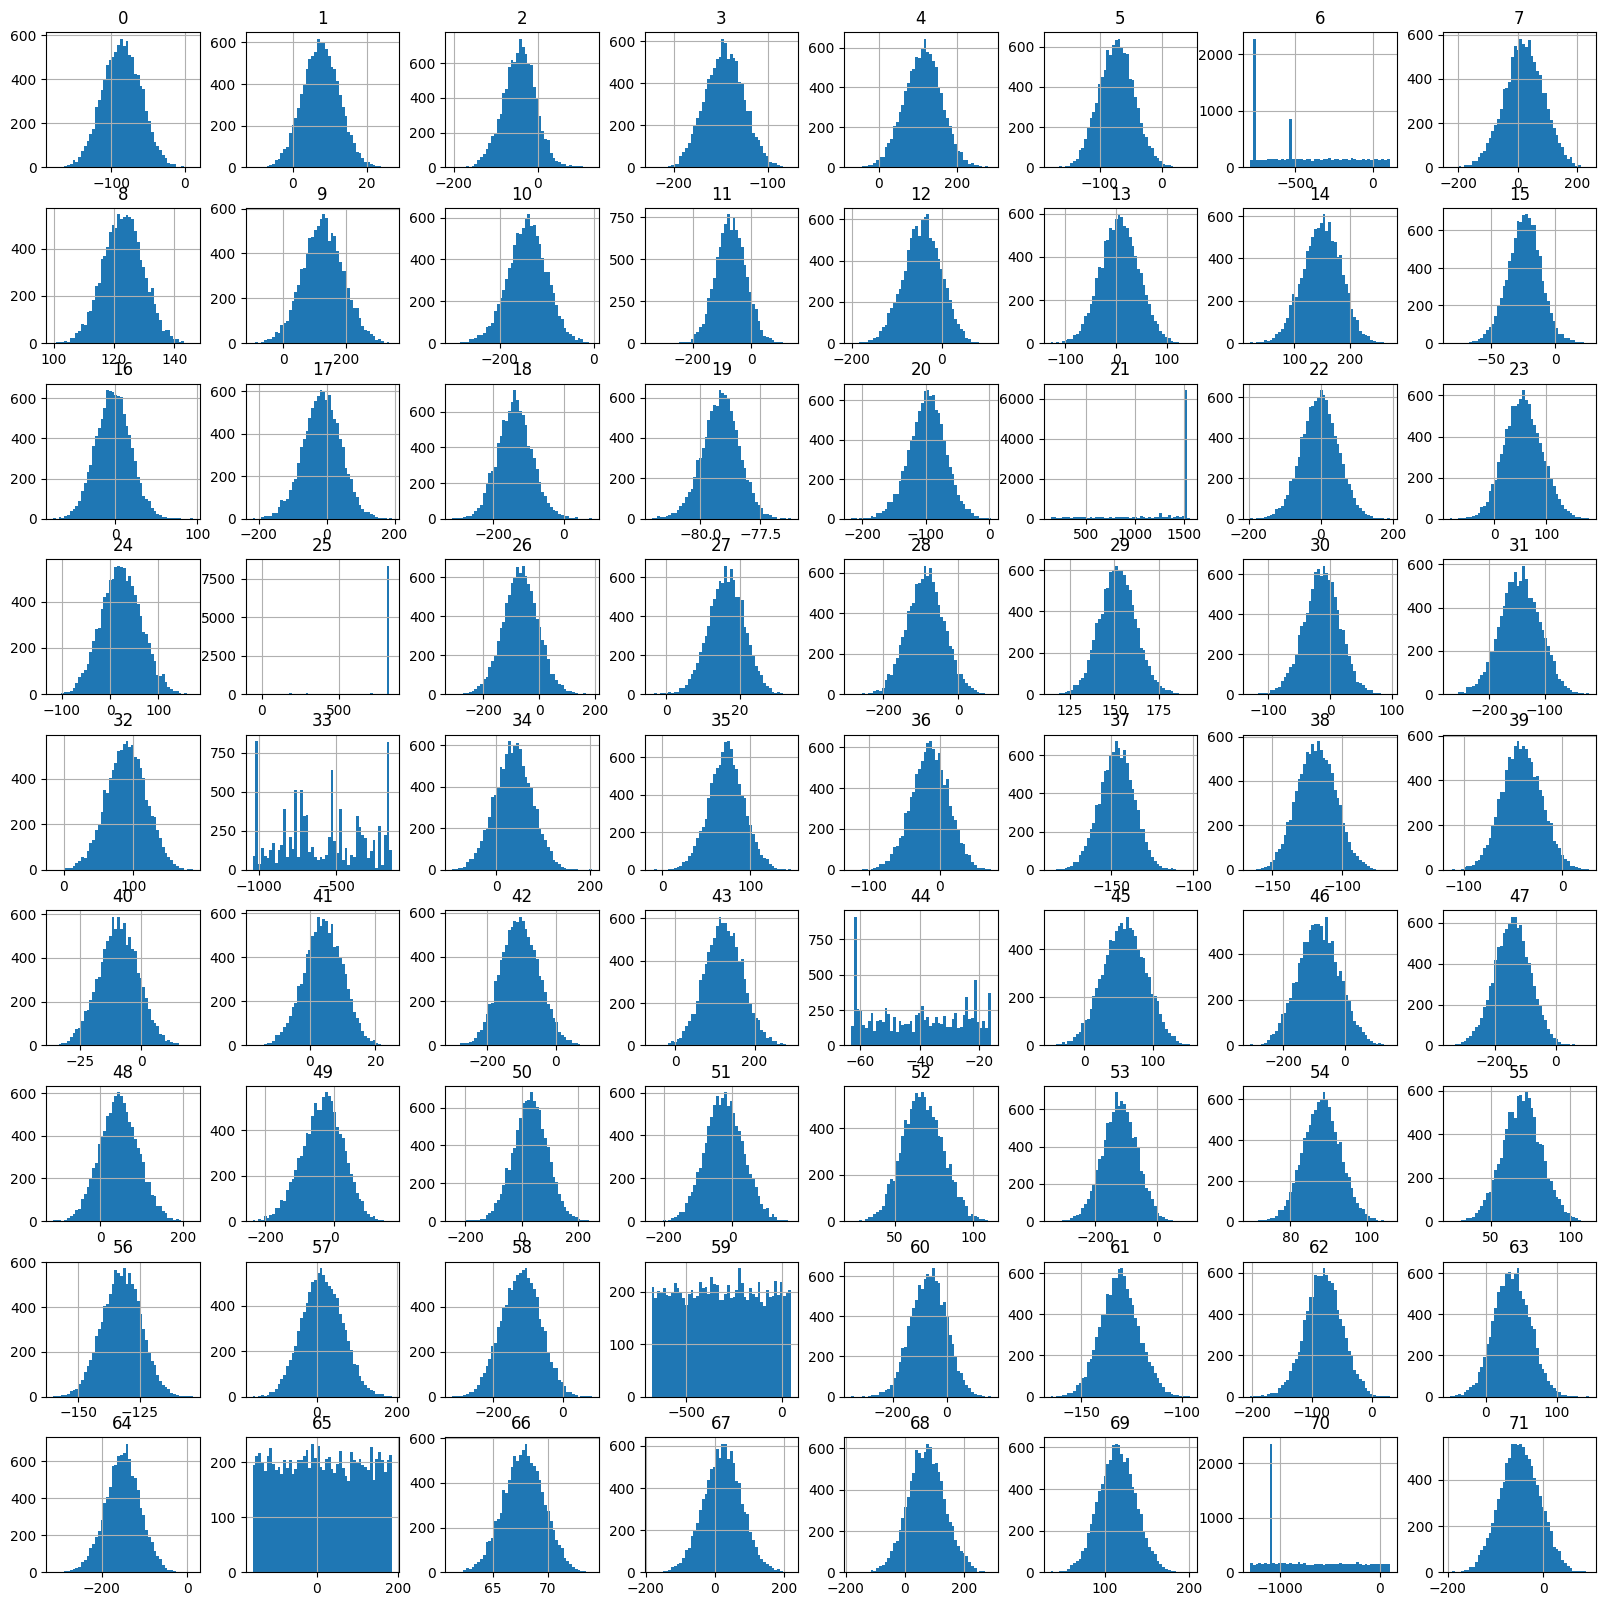

In [25]:
df_samples = df_train[:10000]

df_samples.hist(figsize=[20, 20], bins=50);

Видим, что ряд признаков имеет не нормальной распределение, а именно:
1. **6**
2. **21**;
3. **25**;
4. **33**;
5. **44**;
6. **59**;
7. **65**;
8. **70**.

## Выводы

- Тестовый датасет имеет почти **3 миллиона** объектов;
- Все остальные датасеты имеют ровно **100 тысяч** строк;
- Всего представлено **72 признака** + **1 целевой признак**;
- Каждый из признаков имеет **числовой тип данных с плавающей точкой**;
- Целевой признак имеет строковый тип;
- Все значения признаков замаскированы, то есть, мы **не имеем смыслового представления** этих данных;
- Индекс в датасете - это идентификатор конкретной единицы товара (например, 7500-base или 6400-query);
- Как минимум в валидационном и тренировочном датасетах отсутствуют пропуски. Для тестового датасета метод `info()` не отобразил количество not-null-значений, вероятно, из-за объёма датасета;
- Все признаки, **кроме восьми из них**, имеют нормальное распределение данных;
- Пропуски и дубли в исходных данных отсутствуют.

# Настройка и проверка faiss

Первым делом выделим целевой признак из `df_train` в отдельную переменную `targets`, а сам столбец удалим из тренировочного датасета.

Это необходимо для дальнейшей корректного поиска ближайших соседей.

In [26]:
targets_train = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Далее мы проверим, как работает поиск ближайших соседей при отсутствии какой-либо обработки данных и дополнительных настроек.

Будем использовать индекс `IndexIVFFlat`, а в качестве *квантайзера* (то есть, "разделителя" векторов на кластеры) - индекс `IndexFlatL2`.

Создадим функцию `faiss_search`, которая будет выполнять создание, обучение индекса, поиск ближайших соседей и расчёт метрики `accuracy`.

Функция способна принимать на вход следующие параметры:
- **p_low_cells** - нижняя граница количества кластеров для цикла;
- **p_high_cells** - верхняя граница количества кластеров для цикла;
- **p_step_cells** - шаг по количеству кластеров для цикла;
- **p_num_neighbors** - коилчество ближайших соседей, которых хотим определять;
- **p_normalize_mode** - определение режима работы функции: с нормализацией или без неё.

In [50]:
def faiss_search(df_base=df_base,
                 df_query=df_train,
                 targets=targets_train,
                 p_low_cells=100,
                 p_high_cells=101,
                 p_step_cells=100,
                 p_num_neighbors=5,
                 p_normalize_mode=False):

    # Словарь, связывающий faiss индексы с индексами в df_base
    base_index = {p_num_neighbors: object_id for p_num_neighbors,
                  object_id in enumerate(df_base.index.to_list())}

    # Если необходимо нормализовать данные
    if p_normalize_mode == True:
        # Инициализация объекта масштабирования
        scaler = RobustScaler()

        # Масштабирование df_base
        v_df_base = scaler.fit_transform(df_base)

        # Масштабирование df_query на основе параметров df_base
        v_df_query = scaler.transform(df_query)
    else:
        v_df_base = df_base
        v_df_query = df_query

    start_total_time = time.time()

    # Итерация через различное количество кластеров для индекса IndexIVFFlat
    for cur in tqdm(range(p_low_cells, p_high_cells, p_step_cells), desc='Выполнение цикла'):

        # Начало измерения времени выполнения одного цикла
        start_loop_time = time.time()

        # Получение количества признаков для векторов
        dims = v_df_base.shape[1]

        # Установка текущего количества кластеров для индекса
        n_cells = cur

        # Создание квантайзера с использованием L2 (евклидовой) метрики
        quantizer = faiss.IndexFlatL2(dims)

        # Создание индекса для приближенного поиска ближайших соседей
        idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

        # В зависимости от необходимости нормализации два сценария шагов:
        # 1. Обучение индекса;
        # 2. Добавление в индекс всех векторов;
        # 3. Поиск ближайших соседей
        if p_normalize_mode == True:
            idx_l2.train(np.ascontiguousarray(v_df_base[:50000, :]).
                         astype('float32'))
            idx_l2.add(np.ascontiguousarray(v_df_base).astype('float32'))

            vecs, idx = idx_l2.search(np.ascontiguousarray(v_df_query).
                                  astype('float32'), p_num_neighbors)
        else:
            idx_l2.train(np.ascontiguousarray(v_df_base.values[:50000, :]).
                         astype('float32'))
            idx_l2.add(np.ascontiguousarray(v_df_base.values).astype('float32'))

            vecs, idx = idx_l2.search(np.ascontiguousarray(v_df_query.values).
                      astype('float32'), p_num_neighbors)

        # Инициализация переменной для подсчета успешных попаданий
        matches = 0

        # Цикл по каждому целевому товару и соответствующим ему ближайшим соседям
        for target, el in zip(targets.values.tolist(), idx.tolist()):
            # Считаем, сколько раз "целевой" товар действительно оказался среди
            # ближайших соседей
            matches += int(target in [base_index[r] for r in el])

        # Процентное соотношение успешных попаданий ко всем возможным случаям,
        # т.е. находим Accuracy@5
        print(cur, 'кластеров. \nAccuracy@5 =', 100 * matches / len(idx), '| normalize_mode =', p_normalize_mode)

        # Конец измерения времени выполнения одного цикла
        end_loop_time = time.time()
        print(f'Длительность текущего цикла: {end_loop_time - start_loop_time:.2f} секунд\n')

    # Конец измерения общего времени выполнения
    end_total_time = time.time()
    print(f'Итоговое время: {end_total_time - start_total_time:.2f} секунд')
    print('Matches', matches)
    print('Total items', len(idx))

    return vecs, idx

Запустим функцию `faiss_search` в двух режимах: с нормализацией датасета и без неё. Тем самым, возможно, получится узнать, влияют ли признаки без нормального распределения на результат или нет.

In [51]:
for cur in [False, True]:
    faiss_search(p_low_cells=100, 
                 p_high_cells=101, 
                 p_normalize_mode=cur, 
                 targets=targets_train)

Выполнение цикла:   0%|          | 0/1 [00:00<?, ?it/s]

100 кластеров. 
Accuracy@5 = 60.562 | normalize_mode = False
Длительность текущего цикла: 41.05 секунд

Итоговое время: 41.06 секунд
Matches 60562
Total items 100000


Выполнение цикла:   0%|          | 0/1 [00:00<?, ?it/s]

100 кластеров. 
Accuracy@5 = 63.204 | normalize_mode = True
Длительность текущего цикла: 44.26 секунд

Итоговое время: 44.27 секунд
Matches 63204
Total items 100000


Как видно, разница существенная. В случае с нормализацией результат на 39% лучше, чем без неё. Но всё же в обоих случаях результат недостаточно хорош.

Так или иначе, признаки, который в исходном виде не имеют нормального распределния, явно влияют на качество метрики. Попробуем избавиться от этих признаков и вновь запустить процедуру в обоих режимах:

In [32]:
# Перечисляем в списке названия всех столбцов без нормального распределенния
for cur in ['6', '21', '25', '33', '44', '59', '65', '70']:
    try:
        df_base.drop(cur, axis=1, inplace=True)
    except:
        print('Столбец', cur, 'в датасете df_base уже удалён')

    try:
        df_train.drop(cur, axis=1, inplace=True)
    except:
        print('Столбец', cur, 'в датасете df_train уже удалён')

    try:
        df_validation.drop(cur, axis=1, inplace=True)
    except:
        print('Столбец', cur, 'в датасете df_validation уже удалён')

И вновь запускаем функцию:

In [52]:
'''for cur in [False, True]:
    _, idx = faiss_search(df_base=df_base,
                 df_query=df_train,
                 p_low_cells=20,
                 p_high_cells=121,
                 p_step_cells=50,
                 p_normalize_mode=cur)'''

_, idx_for_train = faiss_search(df_base=df_base,
                 df_query=df_train,
                 p_low_cells=100,
                 p_high_cells=101,
                 p_step_cells=50,
                 p_normalize_mode=True,
                 p_num_neighbors=50,
                 targets=targets_train)

Выполнение цикла:   0%|          | 0/1 [00:00<?, ?it/s]

100 кластеров. 
Accuracy@5 = 68.125 | normalize_mode = True
Длительность текущего цикла: 47.56 секунд

Итоговое время: 47.57 секунд
Matches 68125
Total items 100000


`Accuracy` повысилось до 68%. В данном случае явно помогла нормализация. Поэтому далее будем работать именно с ней.

Значения `idx` (индексы ближайших соседей) сохраним для дальнейшей работы.

# Задача ранжирования

Для того, чтобы повысить качество выдаваемых рекомендаций, выполним задачу ранжирования. То есть:
* Создадим тренировочный датасет, склеив вектор df_base и df_trainб используя список индексов ближайших соседей `idx`;
* Обучим на нём модель `CatBoostClassifier`;
* Выполним предсказание на `df_validation` и посчитаем значение метрики `accuracy@5`.

## Создание тренировочного датасета

Для начала напишем функцию, которая выполняет создание тренировочного датасета, соединяя векторы (признаки) из датасетов df_base и *df_query* (это может быть любой датасет на вход в функцию - в данном случае будет `df_train`).

In [53]:
def create_double_data(df_base, df_query, targets, neighbors_indices, top_n=50):
    """
    Создает тренировочный датасет для модели ранжирования, используя индексы и расстояния ближайших соседей.

    Параметры:
    - df_base: DataFrame с информацией о товарах.
    - df_query: второй DataFrame с товарами.
    - targets: целевые товары для каждого элемента в df_query.
    - neighbors_indices: индексы ближайших соседей для каждого товара.
    - top_n: количество ближайших соседей для использования.

    Возвращается:
    - double_data: DataFrame с парами товаров и бинарной меткой "похожести".
    """

    # Обрезаем список соседей до top_n для каждого товара
    neighbors_indices_top = neighbors_indices[:, :top_n]

    # Получаем ID товаров из df_query и df_base
    query_ids = df_query.index.values
    base_ids = df_base.index.values

    # Инициализация списков для хранения данных
    query_list = []
    candidate_list = []
    labels = []


    # Итерация по каждому товару и его соседям
    for i, (query_id, neighbor_indices) in enumerate(zip(query_ids, neighbors_indices_top)):
        
        # Добавление ID товара и ID соседей в списки
        query_list.extend([query_id] * top_n)
        candidate_list.extend(base_ids[neighbor_indices])

        # Создание меток: 1, если сосед является целевым товаром; 0 - в противном случае
        labels.extend((base_ids[neighbor_indices] == targets[i]).astype(int))

    # Создание DataFrame
    double_data = pd.DataFrame({
        'query_id': query_list,
        'candidate_id': candidate_list,
        'label': labels
    })

    # Добавление признаков для товаров и кандидатов
    double_data = double_data.merge(df_query, left_on='query_id', right_on='Id', how='left')
    double_data = double_data.merge(df_base, left_on='candidate_id', right_on='Id', how='left', suffixes=('_query', '_candidate'))

    return double_data

Выполняем получившуюся фунцкию `create_double_data`, чтобы создать тренировочный датасет для `catboost`:

In [100]:
df_train_double = create_double_data(df_base=df_base,
                             df_query=df_train,
                             targets=targets_train,
                             neighbors_indices=idx_for_train,
                             top_n=5)

Проверим структуру. Ожидаем количество признаков в два раза большее, чем изначальное + `query_id`, `candidate_id` и `label` (далее при обучении удалим эти столбцы).

In [89]:
df_train_double.shape

(200000, 131)

Видно, что теперь у нас действительно стало два вектора.

## Обучение модели `CatBoostClassifier`

Теперь, когда у нас есть тренировочный датасет, создадим функцию, которая будет принимать её на вход и выполнять обучение модели.

In [90]:
def train_model(training_data, catboost_params):
    """
    Обучает модель CatBoost на основе предоставленных данных и параметров.

    Параметры:
    - training_data: DataFrame с данными для обучения модели.
    - catboost_params: словарь с параметрами для модели CatBoost.

    Возвращается:
    - model: обученная модель CatBoost.
    """

    # Определение признаков и целевой переменной
    features = training_data.drop(columns=['query_id', 'candidate_id', 'label'])
    target = training_data['label']

    # Инициализация модели CatBoost
    model = catboost.CatBoostClassifier(**catboost_params)

    # Обучение модели
    model.fit(features, target, verbose=100)

    return model

Функция готова, теперь вызовем её, предварительно определив список гиперпараметров.

In [101]:
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.06,
    'depth': 3,
    'l2_leaf_reg': 4,
    #'subsample': 0.75,
    #'bootstrap_type': 'Bernoulli',
    'rsm': 0.9,
    'random_state': 75,
    'verbose': 100,
}

model = train_model(df_train_double, catboost_params)

0:	learn: 0.6514683	total: 88.3ms	remaining: 44.1s
100:	learn: 0.3071640	total: 11.7s	remaining: 46.1s
200:	learn: 0.2739192	total: 22.4s	remaining: 33.3s
300:	learn: 0.2559536	total: 32.5s	remaining: 21.5s
400:	learn: 0.2438014	total: 43.1s	remaining: 10.6s
499:	learn: 0.2358399	total: 53.6s	remaining: 0us


Модель обучена.

## Тестирование модели на df_validation

Теперь, когда у нас есть готовая модель, мы можем выполнить предсказание с её помощью. Но предварительно потребуется создать аналогичный по структуре датасету `df_base` датасет `df_validation`, т.к. `predict_proba()` сработает только при одинаковых структурах таблиц (той, на которой обучалась модель и на целевой таблице). 

In [102]:
_, idx_validation = faiss_search(df_query=df_validation,
                 p_low_cells=400,
                 p_high_cells=401,
                 p_step_cells=50,
                 p_normalize_mode=True,
                 p_num_neighbors=50,
                 targets=targets_validation)

Выполнение цикла:   0%|          | 0/1 [00:00<?, ?it/s]

400 кластеров. 
Accuracy@5 = 66.36 | normalize_mode = True
Длительность текущего цикла: 21.57 секунд

Итоговое время: 21.58 секунд
Matches 66360
Total items 100000


In [61]:
targets_validation = df_validation_answer["Expected"]

In [104]:
def predict_and_evaluate(df_query, df_base, targets, neighbors_indices, N=5):
    """
    df_query: DataFrame, содержащий товары, для которых мы хотим сгенерировать рекомендации.
    df_base: DataFrame, содержащий товары, которые будут использоваться для поиска ближайших соседей.
    targets: перечень ответов
    neighbors_indices: индексы ближайших соседей
    N: Количество ближайших соседей для ранжирования.
    """

    # Шаг 1: Предсказания
    
    df_double_query = create_double_data(df_base=df_base,
                             neighbors_indices=idx_validation,
                             df_query=df_query,
                             targets=targets,
                             top_n=50)
    
    df_double_query = df_double_query.drop(columns=['query_id', 'candidate_id'])

    probabilities = model.predict_proba(df_double_query)[:, 1]
    
    # Шаг 2: Поиск 5 ближайших соседей

    _, neighbors_idx = faiss_search(df_base=df_base,
                                    df_query=df_validation,
                                    targets=targets_validation,
                                    p_num_neighbors=N,
                                    p_low_cells=400,
                                    p_high_cells=401,
                                    p_normalize_mode=True)
    
    # Шаг 3: Ранжирование с помощью модели
    sorted_candidates_idx = []
    
    for i, idx in enumerate(neighbors_idx):
        # Извлекаем вероятности для текущих соседей
        current_probabilities = probabilities[idx]
        
        # Получаем индексы отсортированных вероятностей в порядке убывания
        sorted_idx = np.argsort(current_probabilities)[::-1]
        
        # Ранжируем текущих соседей с использованием отсортированных индексов и добавляем в результат
        sorted_candidates = np.array(neighbors_idx[i])[sorted_idx]
        sorted_candidates_idx.append(list(sorted_candidates))
    
    #sorted_candidates_idx = [list(np.array(neighbors_idx[i])[np.argsort(probabilities[idx])[::-1]]) for i, idx in enumerate(neighbors_idx)]
    
   # Шаг 4: Вычисление accuracy@5
    correct_predictions = 0
    
    i = 0
    
    for cur in df_validation_answer['Expected']:
        
        v_cur = cur.replace('-base', '')
        
        if v_cur in sorted_candidates_idx[i]:
            correct_predictions += 1
        i += 1


    accuracy_k = correct_predictions / len(sorted_candidates_idx) * 100
    
    print('Готово')
    print('Правильных предсказаний:', correct_predictions)
    print('Всего предсказаний:', i)

    return accuracy_k


Функция готова. Теперь выполним её запуск, где также будет вычислено значение `accuracy@5`

In [107]:
accuracy = predict_and_evaluate(df_query=df_validation,
                                df_base=df_base,
                                targets=targets_validation,
                                neighbors_indices=idx_validation)

accuracy

Выполнение цикла:   0%|          | 0/1 [00:00<?, ?it/s]

400 кластеров. 
Accuracy@5 = 61.859 | normalize_mode = True
Длительность текущего цикла: 17.06 секунд

Итоговое время: 17.07 секунд
Matches 61859
Total items 100000
Готово
Правильных предсказаний: 0
Всего предсказаний: 100000


0.0

# Вывод

*На этом я в итоге застрял.
Подозреваю, что либо неправильно обучаю модель, либо что-то не так делаю на этапе ранжирования.
Один раз получилось добиться ~150 правильных предсказаний из 100000, но даже это в итоге повторить не получается.
faiss выдаёт достаточно вменяемые результаты, а вот с Catboost'ом подружить сейчас получилось*

In [105]:
'''
Здесь выполнял проверку, как модель предсказывает ответы на том же датасете, на котором обучалась
train_score = model.score(df_train_double.drop(columns=['query_id', 'candidate_id', 'label']), df_train_double['label'])

train_score'''

0.92028

In [95]:
'''validation_score = model.score(create_double_data(df_base=df_base,
                             neighbors_indices=idx_validation,
                             df_query=df_validation,
                             targets=targets_validation,
                             top_n=5).drop(columns=['query_id', 'candidate_id']), targets_validation)

validation_score'''

0.0